In [2]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('classic')

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
df = pd.read_csv("https://www.ndbc.noaa.gov/data/realtime2/46268.txt",delim_whitespace=True)
df.info()

df.drop(index=df.index[0],
        axis=0,
        inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   #YY     2201 non-null   object
 1   MM      2201 non-null   object
 2   DD      2201 non-null   object
 3   hh      2201 non-null   object
 4   mm      2201 non-null   object
 5   WDIR    2201 non-null   object
 6   WSPD    2201 non-null   object
 7   GST     2201 non-null   object
 8   WVHT    2201 non-null   object
 9   DPD     2201 non-null   object
 10  APD     2201 non-null   object
 11  MWD     2201 non-null   object
 12  PRES    2201 non-null   object
 13  ATMP    2201 non-null   object
 14  WTMP    2201 non-null   object
 15  DEWP    2201 non-null   object
 16  VIS     2201 non-null   object
 17  PTDY    2201 non-null   object
 18  TIDE    2201 non-null   object
dtypes: object(19)
memory usage: 326.8+ KB


In [4]:
df['WVHT'] = df['WVHT'].astype(float)


In [5]:
df = df.reindex(index=df.index[::-1])

In [6]:
df

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
2200,2022,07,29,00,00,MM,MM,MM,0.6,14,4.9,208,MM,20.1,20.7,MM,MM,MM,MM
2199,2022,07,29,00,30,MM,MM,MM,0.5,14,4.3,201,MM,19.9,20.3,MM,MM,MM,MM
2198,2022,07,29,01,00,MM,MM,MM,0.6,14,5.3,197,MM,21.0,20.2,MM,MM,MM,MM
2197,2022,07,29,01,30,MM,MM,MM,0.6,14,4.9,202,MM,20.9,20.2,MM,MM,MM,MM
2196,2022,07,29,02,00,MM,MM,MM,0.6,14,5.2,195,MM,20.2,20.3,MM,MM,MM,MM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2022,09,12,21,30,MM,MM,MM,0.7,11,5.9,196,MM,23.2,22.8,MM,MM,MM,MM
4,2022,09,12,22,00,MM,MM,MM,0.7,13,5.6,206,MM,23.2,22.8,MM,MM,MM,MM
3,2022,09,12,22,30,MM,MM,MM,0.8,13,5.2,202,MM,23.2,22.8,MM,MM,MM,MM
2,2022,09,12,23,00,MM,MM,MM,0.8,13,5.6,205,MM,23.2,22.7,MM,MM,MM,MM


In [7]:
df.rename(columns={"#YY": "year",
                   "MM": "month",
                   "DD": "day",
                   "hh": "hour",
                   "mm": "minute"})



,year,month,day,hour,minute,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
2200,2022,07,29,00,00,MM,MM,MM,0.6,14,4.9,208,MM,20.1,20.7,MM,MM,MM,MM
2199,2022,07,29,00,30,MM,MM,MM,0.5,14,4.3,201,MM,19.9,20.3,MM,MM,MM,MM
2198,2022,07,29,01,00,MM,MM,MM,0.6,14,5.3,197,MM,21.0,20.2,MM,MM,MM,MM
2197,2022,07,29,01,30,MM,MM,MM,0.6,14,4.9,202,MM,20.9,20.2,MM,MM,MM,MM
2196,2022,07,29,02,00,MM,MM,MM,0.6,14,5.2,195,MM,20.2,20.3,MM,MM,MM,MM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2022,09,12,21,30,MM,MM,MM,0.7,11,5.9,196,MM,23.2,22.8,MM,MM,MM,MM
4,2022,09,12,22,00,MM,MM,MM,0.7,13,5.6,206,MM,23.2,22.8,MM,MM,MM,MM
3,2022,09,12,22,30,MM,MM,MM,0.8,13,5.2,202,MM,23.2,22.8,MM,MM,MM,MM
2,2022,09,12,23,00,MM,MM,MM,0.8,13,5.6,205,MM,23.2,22.7,MM,MM,MM,MM


In [8]:
df['WVHT']


2200    0.6
2199    0.5
2198    0.6
2197    0.6
2196    0.6
       ... 
5       0.7
4       0.7
3       0.8
2       0.8
1       0.8
Name: WVHT, Length: 2200, dtype: float64

This is markdown



In [9]:
train_y = torch.tensor(df['WVHT'].values.astype(np.float32))
train_x = torch.linspace(0,1,train_y.shape[0])

In [10]:
from gpytorch.kernels import RBFKernel, CosineKernel, ScaleKernel, PeriodicKernel
from custom_kernel import MinKernel, AR2Kernel

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
kernel_1 = (
        ScaleKernel(AR2Kernel()) +
        ScaleKernel(MinKernel()) +
        ScaleKernel(RBFKernel())
        )
kernel_2 = (
        ScaleKernel(AR2Kernel()) +
        ScaleKernel(MinKernel()) +
        ScaleKernel(RBFKernel()) +
        ScaleKernel(RBFKernel()*PeriodicKernel())
        )


kernels = [kernel_1, kernel_2]

In [12]:
training_iter = 150




# Use the adam optimizer

# "Loss" for GPs - the marginal log likelihood



In [15]:
models = []
likelihoods = []

for kernel in kernels:
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    optimizer.param_groups[0]['capturable'] = True
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f    noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
    models.append(model)
    likelihoods.append(likelihood)


Iter 1/150 - Loss: 0.758    noise: 0.693
Iter 2/150 - Loss: 0.720    noise: 0.644
Iter 3/150 - Loss: 0.684    noise: 0.598
Iter 4/150 - Loss: 0.646    noise: 0.554
Iter 5/150 - Loss: 0.608    noise: 0.513
Iter 6/150 - Loss: 0.570    noise: 0.474
Iter 7/150 - Loss: 0.530    noise: 0.437
Iter 8/150 - Loss: 0.491    noise: 0.403
Iter 9/150 - Loss: 0.451    noise: 0.370
Iter 10/150 - Loss: 0.409    noise: 0.340
Iter 11/150 - Loss: 0.368    noise: 0.312
Iter 12/150 - Loss: 0.326    noise: 0.286
Iter 13/150 - Loss: 0.284    noise: 0.261
Iter 14/150 - Loss: 0.241    noise: 0.239
Iter 15/150 - Loss: 0.198    noise: 0.218
Iter 16/150 - Loss: 0.154    noise: 0.199
Iter 17/150 - Loss: 0.110    noise: 0.181
Iter 18/150 - Loss: 0.066    noise: 0.165
Iter 19/150 - Loss: 0.022    noise: 0.150
Iter 20/150 - Loss: -0.022    noise: 0.136
Iter 21/150 - Loss: -0.067    noise: 0.124
Iter 22/150 - Loss: -0.112    noise: 0.112
Iter 23/150 - Loss: -0.156    noise: 0.102
Iter 24/150 - Loss: -0.201    noise: 0.

C:\anaconda3\envs\MortKernel-gpytorch\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.802274227142334 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


In [17]:
from utils import get_BIC

for i in range(len(kernels)):
    print(get_BIC(models[i], likelihoods[i], train_y, train_x))


tensor(-3649.8838, grad_fn=<AddBackward0>)
tensor(-3653.6257, grad_fn=<AddBackward0>)


In [29]:
model = models[0]
likelihood = likelihoods[0]

In [30]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0,1.5,1000)
    observed_pred = likelihood(model(test_x))

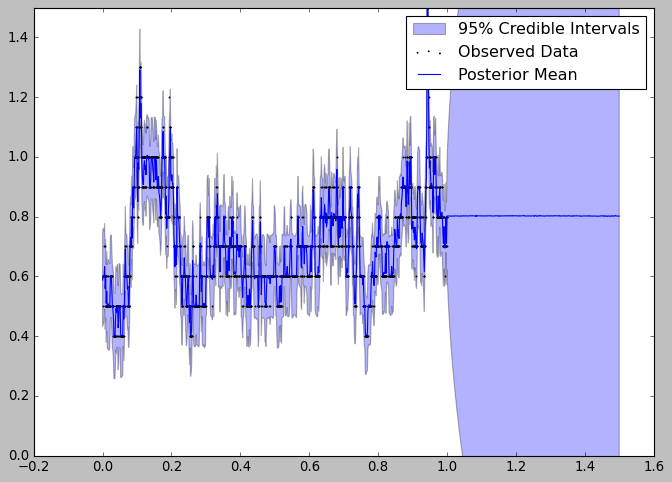

In [31]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 7))

# Get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.detach().cpu().numpy(),
                lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), alpha=0.3)
# Plot training data as black stars
ax.scatter(train_x.detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
# Plot predictive means as blue line
ax.plot(test_x.detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')

ax.set_ylim([0, 1.5])
#ax.patch.set_facecolor('green')
#ax.patch.set_alpha(.1)
ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])
